In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
from phantoms.utils.CKA.CKA import linear_CKA, kernel_CKA
import umap.umap_ as umap
import itertools
from tqdm import tqdm
import re

In [2]:
def load_embeddings(experiment_dir, layer_names):
    """
    Load embeddings for specified layers from a given experiment directory.
    """
    embeddings = {}
    for layer in layer_names:
        layer_path = os.path.join(experiment_dir, f"{layer}.npy")
        if os.path.exists(layer_path):
            embeddings[layer] = np.load(layer_path)
        else:
            print(f"Warning: {layer_path} not found.")
    return embeddings



def compute_layer_cka(embeddings_model1, embeddings_model2, layer_name1, layer_name2):
    """
    Compute CKA scores between two sets of embeddings for a specific layer.
    """
    X = embeddings_model1.get(layer_name1)
    Y = embeddings_model2.get(layer_name2)
    
    if X is None or Y is None:
        print(f"Embeddings for layer '{layer_name1}' or '{layer_name2}' are missing.")
        return None, None

    X = X.T
    Y = Y.T

    linear_cka_score = linear_CKA(X, Y)
    rbf_cka_score = kernel_CKA(X, Y)
    
    return linear_cka_score, rbf_cka_score

def compute_cka_matrix_for_experiment(experiment_dir, layer_names):
    """
    For a single experiment directory, load the embeddings and compute a 3D
    CKA matrix of shape [num_layers, num_layers, 2] where the last dimension
    corresponds to (linear, RBF) CKA scores.
    """
    print(f"\nProcessing experiment: {experiment_dir}")
    embeddings = load_embeddings(experiment_dir, layer_names)
    num_layers = len(layer_names)
    cka_matrix = np.zeros((num_layers, num_layers, 2))
    
    # Loop over all pairs of layers
    for i, layer1 in enumerate(tqdm(layer_names, desc="Outer loop")):
        for j, layer2 in enumerate(layer_names):
            linear_cka, rbf_cka = compute_layer_cka(embeddings, embeddings, layer1, layer2)
            if linear_cka is not None and rbf_cka is not None:
                cka_matrix[i, j, 0] = linear_cka
                cka_matrix[i, j, 1] = rbf_cka
    return cka_matrix

def compute_all_cka_matrices(experiment_dirs, layer_names):
    """
    Compute a dictionary mapping each experiment directory (or label) to its 
    corresponding 3D CKA matrix.
    """
    cka_matrices = {}
    for exp_dir in experiment_dirs:
        cka_matrices[exp_dir] = compute_cka_matrix_for_experiment(exp_dir, layer_names)
    return cka_matrices

def plot_all_heatmaps(cka_matrices, layer_names, metric='linear', max_value='inter'):
    """
    Plot a 2x2 grid of heatmaps corresponding to the CKA matrices computed
    for different experiment directories.

    Args:
        cka_matrices (dict): Dictionary with keys as experiment directory paths 
                             and values as CKA matrices (shape: [num_layers, num_layers, 2]).
        layer_names (list): List of layer names (used for x- and y-axis labels).
        metric (str): 'linear' for linear CKA or 'rbf' for RBF kernel CKA.
        max_value (str): 'inter' to scale each heatmap independently by its maximum 
                         off-diagonal value, or 'outer' to use the maximum off-diagonal 
                         value across all heatmaps for a common scale.
    """
    # Determine the index for the selected metric: 0 for linear, 1 for RBF.
    metric_idx = 0 if metric.lower() == 'linear' else 1
    
    # If using outer scaling, compute the global maximum (off-diagonal) across all experiments.
    global_max = None
    if max_value == 'outer':
        max_vals = []
        for cka_matrix in cka_matrices.values():
            data = cka_matrix[:, :, metric_idx]
            mask = np.eye(data.shape[0], dtype=bool)
            if np.sum(~mask) > 0:
                max_vals.append(np.max(data[~mask]))
        if max_vals:
            global_max = np.max(max_vals)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for ax, (exp_dir, cka_matrix) in zip(axes, cka_matrices.items()):
        data = cka_matrix[:, :, metric_idx]
        mask = np.eye(data.shape[0], dtype=bool)
        
        # Determine vmax: if 'outer', use global_max; else compute for this heatmap.
        if max_value == 'outer':
            vmax = global_max
        else:
            # Compute maximum from off-diagonals for this heatmap.
            if np.sum(~mask) > 0:
                vmax = np.max(data[~mask])
            else:
                vmax = None

        # sns.heatmap(data, ax=ax, annot=False, fmt=".2f",
        #             xticklabels=layer_names, yticklabels=layer_names,
        #             cmap='coolwarm', mask=mask, vmin=0, vmax=vmax)
        
        
        # Plot the heatmap with the diagonal masked.
        sns.heatmap(data, ax=ax, annot=False, fmt=".2f",
                    xticklabels=layer_names, yticklabels=layer_names,
                    cmap='Oranges', mask=mask, vmin=0, vmax=vmax)
        
        # Overlay pink patches on the diagonal cells.
        # Each cell in the heatmap is 1x1 in the coordinate system.
        for i in range(len(layer_names)):
            # (i, i) is the lower left corner of the diagonal cell.
            ax.add_patch(patches.Rectangle((i, i), 1, 1, fill=True, color='pink', lw=0, zorder=3))

        
        # Extract a simple title from the experiment directory (e.g. "cut_tree_3")
        match = re.search(r'cut_tree_\d+', exp_dir)
        if match:
            title = match.group(0)
        else:
            title = os.path.basename(exp_dir)
            
        ax.set_title(f"{title}\n{metric.upper()} CKA", fontsize=10)
        ax.set_xlabel("Layers")
        ax.set_ylabel("Layers")
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)
    
    plt.suptitle(f"Intra-Model {metric.upper()} CKA Heatmaps (Diagonal Masked)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def compute_inter_model_cka(exp_dirs, layer_names, metric='linear'):
    """
    Computes inter-model CKA similarities for corresponding layers across multiple models.
    
    Args:
        exp_dirs (list): List of experiment directory paths (each for one model).
        layer_names (list): List of layer names (assumed common across models).
        metric (str): 'linear' for linear CKA or 'rbf' for kernel CKA.
    
    Returns:
        dict: Mapping from layer name to a list of CKA similarity scores (one per pair of models).
    """
    models_embeddings = {}
    for exp_dir in exp_dirs:
        models_embeddings[exp_dir] = load_embeddings(exp_dir, layer_names)
        
    layer_similarities = {layer: [] for layer in layer_names}
    
    # Iterate over each layer.
    for layer in layer_names:
        # Iterate over all unique pairs of models.
        for (exp1, emb1), (exp2, emb2) in itertools.combinations(models_embeddings.items(), 2):
            # Compute CKA similarity for the given layer from both models.
            linear_cka, rbf_cka = compute_layer_cka(emb1, emb2, layer, layer)
            if metric.lower() == 'linear':
                score = linear_cka
            else:
                score = rbf_cka
            if score is not None:
                layer_similarities[layer].append(score)
    return layer_similarities

def plot_inter_model_cka(layer_similarities, metric='linear'):
    """
    Plots a line plot where the x-axis is the layer index (or name) and the y-axis is the 
    average inter-model CKA similarity for that layer (with error bars).
    
    Args:
        layer_similarities (dict): Mapping from layer name to list of CKA scores.
        metric (str): 'linear' or 'rbf' indicating the type of CKA used.
    """
    layers = list(layer_similarities.keys())
    means = []
    stds = []
    for layer in layers:
        scores = np.array(layer_similarities[layer])
        means.append(np.mean(scores))
        stds.append(np.std(scores))
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(range(len(layers)), means, yerr=stds, fmt='-o', capsize=5, color='tab:blue')
    plt.xticks(range(len(layers)), layers, rotation=45, ha='right')
    plt.xlabel("Layer")
    plt.ylabel(f"Average {metric.upper()} CKA")
    plt.title(f"Inter-Model {metric.upper()} CKA Across Corresponding Layers")
    plt.tight_layout()
    plt.show()

def project_embeddings_umap(embeddings_dict, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42, figsize=(12, 10), save_path=None):
    """
    Projects embeddings into 2D space using UMAP and plots them colored by layer.

    Args:
        embeddings_dict (dict): A dictionary where keys are layer names and values are np arrays of shape [num_samples, embedding_dim].
        n_neighbors (int): UMAP parameter. Controls local versus global structure in the data.
        min_dist (float): UMAP parameter. Controls how tightly UMAP packs points together.
        metric (str): UMAP parameter. The metric to use for distance computation.
        random_state (int): Random state for reproducibility.
        figsize (tuple): Size of the matplotlib figure.
        save_path (str, optional): If provided, saves the plot to the specified path.

    Returns:
        None
    """

    if not isinstance(embeddings_dict, dict):
        raise ValueError("embeddings_dict must be a dictionary with layer names as keys and embedding arrays as values.")

    all_embeddings = []
    labels = []
    for layer, emb in embeddings_dict.items():
        if not isinstance(emb, np.ndarray):
            raise ValueError(f"Embeddings for layer '{layer}' must be a NumPy array.")
        all_embeddings.append(emb)
        labels.extend([layer] * emb.shape[0])

    concatenated_embeddings = np.concatenate(all_embeddings, axis=0)
    print(f"Total embeddings shape after concatenation: {concatenated_embeddings.shape}")

    df_embeddings = pd.DataFrame(concatenated_embeddings)
    df_embeddings['Layer'] = labels

    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=random_state)

    embedding_2d = reducer.fit_transform(df_embeddings.drop('Layer', axis=1))
    df_embeddings['UMAP1'] = embedding_2d[:, 0]
    df_embeddings['UMAP2'] = embedding_2d[:, 1]

    print(f"UMAP embedding shape: {embedding_2d.shape}")

    plt.figure(figsize=figsize)
    sns.scatterplot(
        data=df_embeddings,
        x='UMAP1',
        y='UMAP2',
        hue='Layer',
        palette='tab10',
        s=50,
        alpha=0.7
    )
    plt.title('UMAP Projection of Layer Embeddings', fontsize=16)
    plt.xlabel('UMAP1', fontsize=14)
    plt.ylabel('UMAP2', fontsize=14)
    plt.legend(title='Layer', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"UMAP plot saved to {save_path}")

    plt.show()



def plot_all_heatmaps_threshold_mask(cka_matrices, layer_names, metric='linear', max_value='inter', threshold=0.2):
    """
    Plot a 2x2 grid of heatmaps corresponding to the CKA matrices computed
    for different experiment directories, masking all values greater than or equal 
    to a given threshold. Masked cells are overlaid with pink.

    Args:
        cka_matrices (dict): Dictionary with keys as experiment directory paths 
                             and values as CKA matrices (shape: [num_layers, num_layers, 2]).
        layer_names (list): List of layer names (used for x- and y-axis labels).
        metric (str): 'linear' for linear CKA or 'rbf' for RBF kernel CKA.
        max_value (str): 'inter' to scale each heatmap independently by its maximum
                         unmasked value, or 'outer' to use the maximum unmasked value
                         across all heatmaps for a common scale.
        threshold (float): All values in the CKA matrices that are >= threshold will be masked.
    """
    # Determine the index for the selected metric: 0 for linear, 1 for RBF.
    metric_idx = 0 if metric.lower() == 'linear' else 1

    # If using outer scaling, compute the global maximum from unmasked values across experiments.
    global_max = None
    if max_value == 'outer':
        max_vals = []
        for cka_matrix in cka_matrices.values():
            data = cka_matrix[:, :, metric_idx]
            # Mask cells where the value is >= threshold.
            mask = data >= threshold
            if np.sum(~mask) > 0:
                max_vals.append(np.max(data[~mask]))
        if max_vals:
            global_max = np.max(max_vals)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for ax, (exp_dir, cka_matrix) in zip(axes, cka_matrices.items()):
        data = cka_matrix[:, :, metric_idx]
        # Create a mask for all cells where value is >= threshold.
        mask = data >= threshold

        # Determine vmax: if using outer scaling, use global_max; otherwise compute local maximum from unmasked cells.
        if max_value == 'outer':
            vmax = global_max
        else:
            if np.sum(~mask) > 0:
                vmax = np.max(data[~mask])
            else:
                vmax = None

        # Plot heatmap with cells >= threshold masked.
        sns.heatmap(data, ax=ax, annot=False, fmt=".2f",
                    xticklabels=layer_names, yticklabels=layer_names,
                    cmap='Oranges', mask=mask, vmin=0, vmax=vmax)

        # Overlay pink patches on each masked cell.
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if mask[i, j]:
                    # Note: In seaborn heatmap, x corresponds to columns and y to rows.
                    ax.add_patch(patches.Rectangle((j, i), 1, 1, fill=True, color='pink', lw=0, zorder=3))

        # Extract a simple title from the experiment directory (e.g. "cut_tree_3")
        match = re.search(r'cut_tree_\d+', exp_dir)
        if match:
            title = match.group(0)
        else:
            title = os.path.basename(exp_dir)

        ax.set_title(f"{title}\n{metric.upper()} CKA", fontsize=10)
        ax.set_xlabel("Layers")
        ax.set_ylabel("Layers")
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)

    plt.suptitle(f"Intra-Model {metric.upper()} CKA Heatmaps (Values >= {threshold} Masked)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [3]:
# Specify the layers you want to compare
layer_names = ['gnn_1_head_1_mean',
'gnn_1_head_2_mean',
'gnn_1_head_3_mean',
'gnn_1_head_4_mean',
'gnn_2_head_1_mean',
'gnn_2_head_2_mean',
'gnn_2_head_3_mean',
'gnn_2_head_4_mean',
'gnn_3_head_1_mean',
'gnn_3_head_2_mean',
'gnn_3_head_3_mean',
'gnn_3_head_4_mean',
'head_head_fc1',
'head_skipblock_1_hidden1',
'head_skipblock_1_hidden2',
'head_skipblock_2_hidden1',
'head_skipblock_2_hidden2',
'head_skipblock_3_hidden1',
'head_skipblock_3_hidden2',
'head_skipblock_4_hidden1',
'head_skipblock_4_hidden2', 
'head_skipblock_5_hidden1',
'head_skipblock_5_hidden2',
'head_skipblock_6_hidden1',
'head_skipblock_6_hidden2',
'head_head_fc_final',
]

# Dreams

In [4]:
experiment_dreams = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_0_2025-02-19_14-51-13',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_1_2025-02-19_15-31-19',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_2_2025-02-19_16-12-30',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_3_2025-02-19_16-56-31'
]

In [5]:
cka_matrices_dreams = compute_all_cka_matrices(experiment_dreams, layer_names)


Processing experiment: /Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_0_2025-02-19_14-51-13


Outer loop: 100%|██████████| 26/26 [05:19<00:00, 12.30s/it]



Processing experiment: /Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_1_2025-02-19_15-31-19


Outer loop: 100%|██████████| 26/26 [04:23<00:00, 10.14s/it]



Processing experiment: /Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_2_2025-02-19_16-12-30


Outer loop: 100%|██████████| 26/26 [04:25<00:00, 10.20s/it]



Processing experiment: /Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_3_2025-02-19_16-56-31


Outer loop: 100%|██████████| 26/26 [04:15<00:00,  9.84s/it]


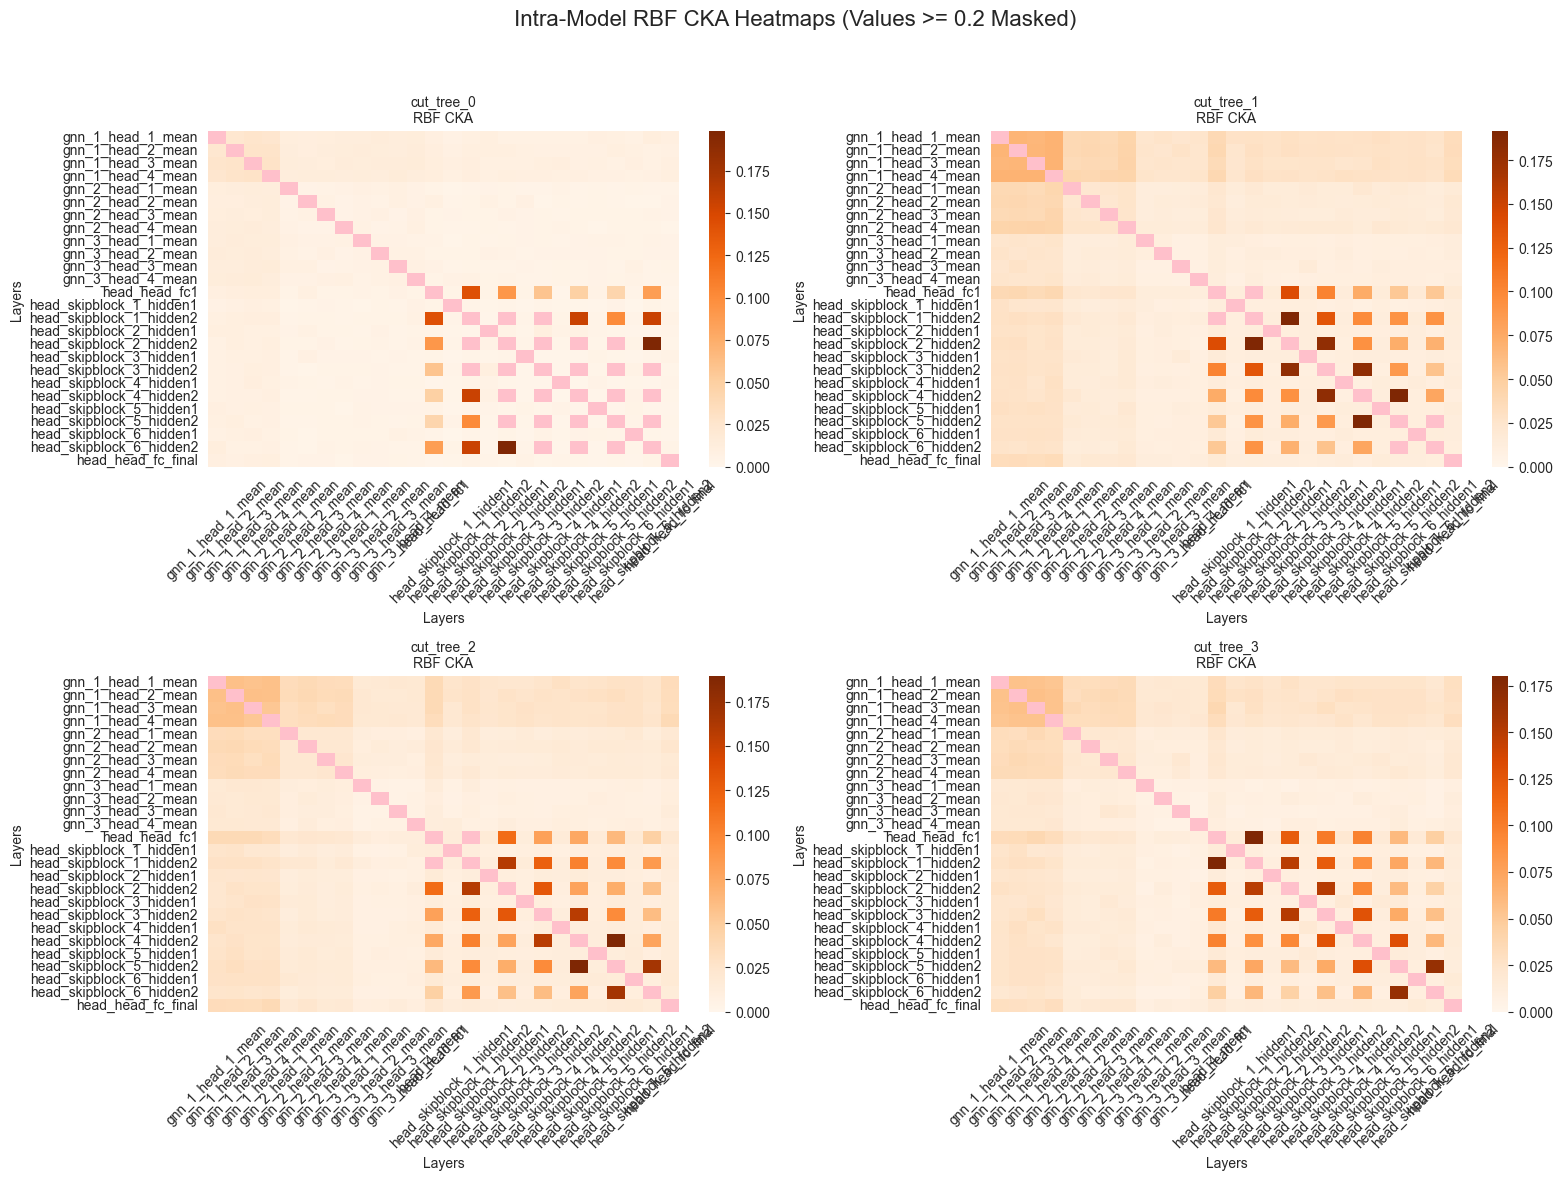

In [6]:
plot_all_heatmaps_threshold_mask(cka_matrices_dreams, layer_names, metric='rbf', max_value='inter', threshold=0.2)

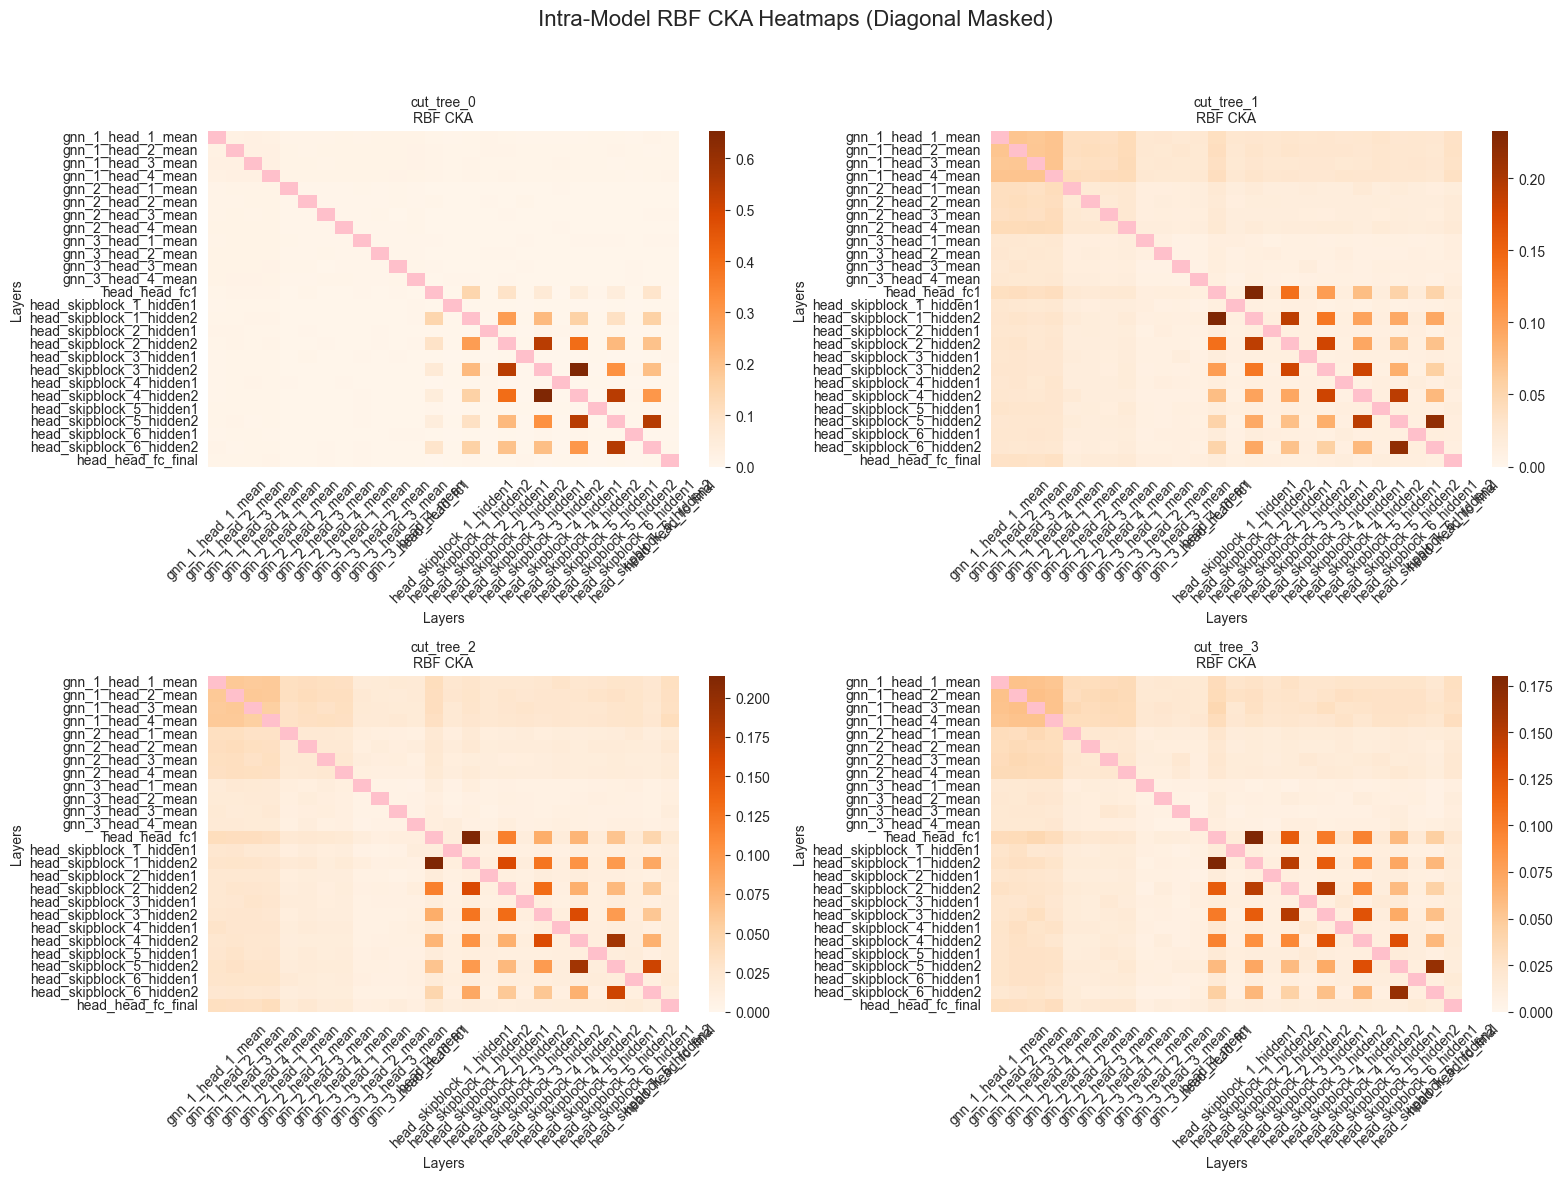

In [7]:
plot_all_heatmaps(cka_matrices_dreams, layer_names, metric='rbf', max_value='inter')

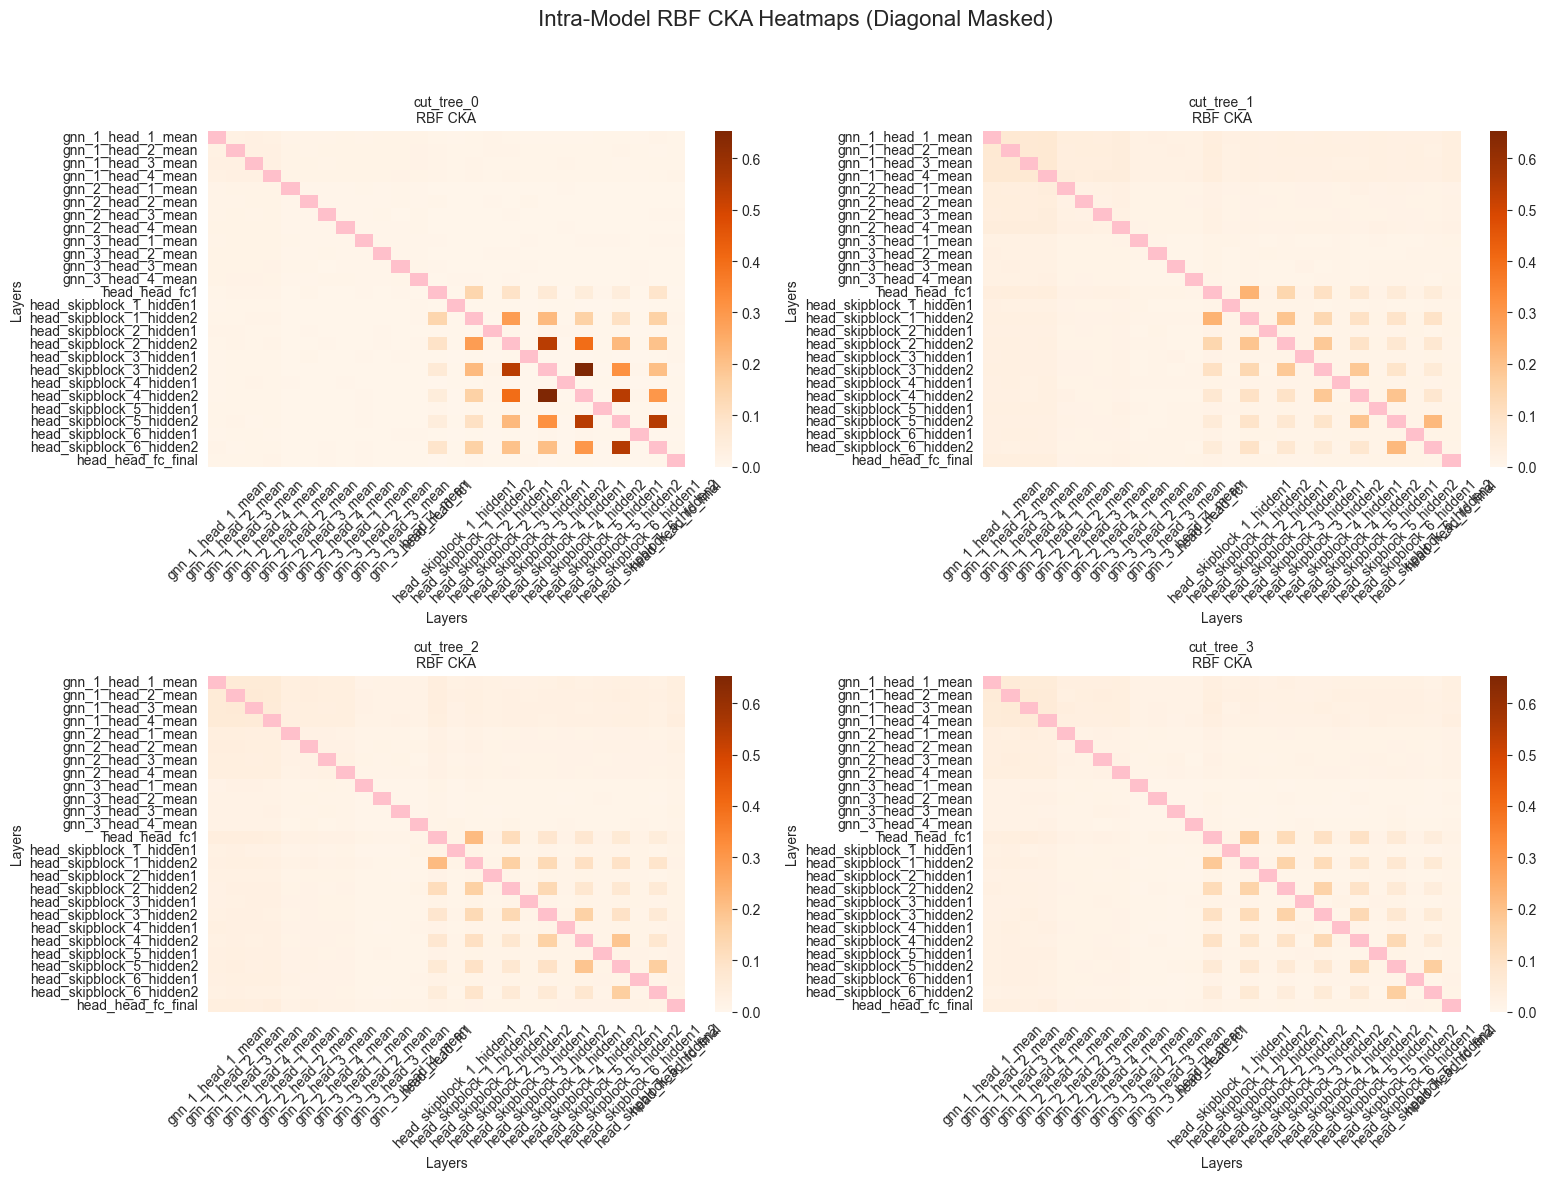

In [8]:
plot_all_heatmaps(cka_matrices_dreams, layer_names, metric='rbf', max_value='outer')

# Dreams Bonus

In [9]:
experiment_dreams_bonus = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_0_2025-02-19_17-38-07',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_1_2025-02-19_18-24-19',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_2_2025-02-19_19-10-33',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_3_2025-02-19_19-57-08'
]

In [ ]:
cka_matrices_dreams_bonus = compute_all_cka_matrices(experiment_dreams_bonus, layer_names)


Processing experiment: /Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_0_2025-02-19_17-38-07


Outer loop: 100%|██████████| 26/26 [03:56<00:00,  9.10s/it]



Processing experiment: /Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_1_2025-02-19_18-24-19


Outer loop: 100%|██████████| 26/26 [04:04<00:00,  9.39s/it]



Processing experiment: /Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_2_2025-02-19_19-10-33


Outer loop:  58%|█████▊    | 15/26 [02:21<01:45,  9.57s/it]

In [ ]:
plot_all_heatmaps_threshold_mask(cka_matrices_dreams_bonus, layer_names, metric='rbf', max_value='inter', threshold=0.2)

In [ ]:
plot_all_heatmaps(cka_matrices_dreams_bonus, layer_names, metric='rbf', max_value='inter')

In [ ]:
plot_all_heatmaps(cka_matrices_dreams_bonus, layer_names, metric='rbf', max_value='outer')

# Raw Spectra

In [ ]:
experiment_raw_spectra = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_0_2025-02-19_09-00-57',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_1_2025-02-19_09-38-36',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_2_2025-02-19_10-20-04',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_3_2025-02-19_11-02-28'
]

In [ ]:
cka_matrices_raw_spectra = compute_all_cka_matrices(experiment_raw_spectra, layer_names)

In [ ]:
plot_all_heatmaps_threshold_mask(cka_matrices_raw_spectra, layer_names, metric='rbf', max_value='inter', threshold=0.2)

In [ ]:
plot_all_heatmaps(cka_matrices_raw_spectra, layer_names, metric='rbf', max_value='inter')

In [ ]:
plot_all_heatmaps(cka_matrices_raw_spectra, layer_names, metric='rbf', max_value='outer')

# Raw Spectra Bonus

In [ ]:
experiment_raw_spectra_bonus = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_0_2025-02-19_11-44-59',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_1_2025-02-19_12-31-04',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_2_2025-02-19_13-16-56',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_3_2025-02-19_14-04-53'
]

In [ ]:
cka_matrices_raw_spectra_bonus = compute_all_cka_matrices(experiment_raw_spectra_bonus, layer_names)

In [ ]:
plot_all_heatmaps_threshold_mask(cka_matrices_raw_spectra_bonus, layer_names, metric='rbf', max_value='inter', threshold=0.2)

In [ ]:
plot_all_heatmaps(cka_matrices_raw_spectra_bonus, layer_names, metric='rbf', max_value='inter')

In [ ]:
plot_all_heatmaps(cka_matrices_raw_spectra_bonus, layer_names, metric='rbf', max_value='outer')

# Heatmap by levels

## level 2

In [ ]:
experiment_level_2 = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_0_2025-02-19_09-00-57',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_0_2025-02-19_11-44-59',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_0_2025-02-19_14-51-13',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_0_2025-02-19_17-38-07',
]

In [ ]:
cka_matrices_level_2 = compute_all_cka_matrices(experiment_level_2, layer_names)

In [ ]:
plot_all_heatmaps_threshold_mask(cka_matrices_level_2, layer_names, metric='rbf', max_value='inter', threshold=0.2)

In [ ]:
plot_all_heatmaps(cka_matrices_level_2, layer_names, metric='rbf', max_value='inter')

In [ ]:
plot_all_heatmaps(cka_matrices_level_2, layer_names, metric='rbf', max_value='outer')

## level 3

In [ ]:
experiment_level_3 = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_1_2025-02-19_09-38-36',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_1_2025-02-19_12-31-04',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_1_2025-02-19_15-31-19',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_1_2025-02-19_18-24-19',
]

In [ ]:
cka_matrices_level_3 = compute_all_cka_matrices(experiment_level_3, layer_names)

In [ ]:
plot_all_heatmaps_threshold_mask(cka_matrices_level_3, layer_names, metric='rbf', max_value='inter', threshold=0.2)

In [ ]:
plot_all_heatmaps(cka_matrices_level_3, layer_names, metric='rbf', max_value='inter')

In [ ]:
plot_all_heatmaps(cka_matrices_level_3, layer_names, metric='rbf', max_value='outer')

# level 4

In [ ]:
experiment_level_4 = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_2_2025-02-19_10-20-04',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_2_2025-02-19_13-16-56',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_2_2025-02-19_16-12-30',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_2_2025-02-19_19-10-33',
]

In [ ]:
cka_matrices_level_4 = compute_all_cka_matrices(experiment_level_4, layer_names)

In [ ]:
plot_all_heatmaps_threshold_mask(cka_matrices_level_4, layer_names, metric='rbf', max_value='inter', threshold=0.2)

In [ ]:
plot_all_heatmaps(cka_matrices_level_4, layer_names, metric='rbf', max_value='inter')

In [ ]:
plot_all_heatmaps(cka_matrices_level_4, layer_names, metric='rbf', max_value='outer')

# level 5

In [ ]:
experiment_level_5 = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_3_2025-02-19_11-02-28',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_3_2025-02-19_14-04-53',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_3_2025-02-19_16-56-31',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_3_2025-02-19_19-57-08',
]

In [ ]:
cka_matrices_level_5 = compute_all_cka_matrices(experiment_level_5, layer_names)

In [ ]:
plot_all_heatmaps_threshold_mask(cka_matrices_level_5, layer_names, metric='rbf', max_value='inter', threshold=0.2)

In [ ]:
plot_all_heatmaps(cka_matrices_level_5, layer_names, metric='rbf', max_value='inter')

In [ ]:
plot_all_heatmaps(cka_matrices_level_5, layer_names, metric='rbf', max_value='outer')